In [10]:
# =======================================
# 1) DOWNLOAD + UNZIP MRL EYE DATASET
# =======================================



!mkdir -p mrl
!unzip -q mrl.zip -d mrl

print("MRL Dataset Download + Unzip Complete ✔")


MRL Dataset Download + Unzip Complete ✔


In [6]:
!pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 17.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 34.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyctcdecode 0.5.0 requires numpy<2.0.0,>=1.15.0, but you have numpy 2.2.6 which is incompatible.


In [12]:
!pip install torchsummary


In [8]:
torch.save(model.state_dict(), "trained_model.pth")


MobileNetV3-Large 

Using: cuda
Total subjects found: 37

Subject split:
Train subjects: 25
Val subjects  : 4
Test subjects : 8

Image counts:
Train images: 57261
Val images  : 6252
Test images : 21385

Final dataset sizes: 57261 6252 21385

======== MODEL SUMMARY ========
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         Hardswish-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             256
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 64, 6

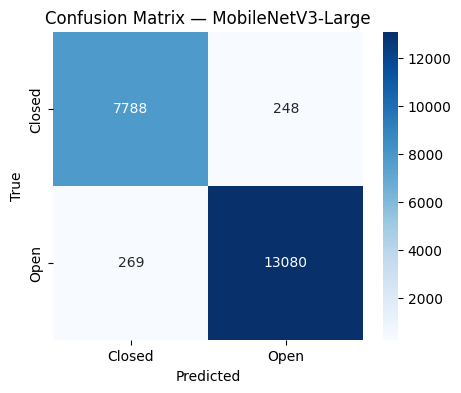

In [ ]:
# ======================================================
# MRL Eye Dataset — MobileNetV3-Large + Summary + Confusion Matrix
# ======================================================

import os, glob, cv2, random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# DEVICE + SEED
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ======================================================
# DATASET 
# ======================================================
class MRLDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fpath = self.files[idx]

        # Load grayscale
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))

        label = int(os.path.basename(fpath).split("_")[4])

        if self.transform:
            img = self.transform(img)

        return img, label

# ======================================================
# SUBJECT-WISE SPLIT
# ======================================================
root = "mrl/mrlEyes_2018_01"

subjects = [
    os.path.join(root, s)
    for s in os.listdir(root)
    if os.path.isdir(os.path.join(root, s))
]

print("Total subjects found:", len(subjects))
random.shuffle(subjects)

n = len(subjects)
train_subjects = subjects[:int(0.7*n)]
val_subjects   = subjects[int(0.7*n):int(0.8*n)]
test_subjects  = subjects[int(0.8*n):]

print("\nSubject split:")
print("Train subjects:", len(train_subjects))
print("Val subjects  :", len(val_subjects))
print("Test subjects :", len(test_subjects))


def collect_files(subj_list):
    files = []
    for s in subj_list:
        files += glob.glob(s + "/**/*.png", recursive=True)
    return files

train_files = collect_files(train_subjects)
val_files   = collect_files(val_subjects)
test_files  = collect_files(test_subjects)

print("\nImage counts:")
print("Train images:", len(train_files))
print("Val images  :", len(val_files))
print("Test images :", len(test_files))

# ======================================================
# TRANSFORMS 
# ======================================================
train_tfms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=3),  
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

test_tfms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=3),  
    T.ToTensor()
])

# ======================================================
# DATA LOADERS
# ======================================================
train_ds = MRLDataset(train_files, transform=train_tfms)
val_ds   = MRLDataset(val_files,   transform=test_tfms)
test_ds  = MRLDataset(test_files,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

print("\nFinal dataset sizes:", len(train_ds), len(val_ds), len(test_ds))

# ======================================================
# MobileNetV3-Large 
# ======================================================
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

def get_mobilenet_v3(num_classes=2):
    weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2
    model = mobilenet_v3_large(weights=weights)

    # Replace classifier head
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)

    return model.to(device)

model = get_mobilenet_v3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ======================================================
# MODEL SUMMARY 
# ======================================================
print("\n======== MODEL SUMMARY ========")
try:
    from torchsummary import summary
    summary(model, input_size=(3, 128, 128))  # RGB input
except:
    print("torchsummary ")

# ======================================================
# TRAINING LOOP
# ======================================================
def train_model(model, epochs=10):
    for ep in range(epochs):
        model.train()
        total, correct = 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # VALIDATION
        model.eval()
        v_correct, v_total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(1)
                v_correct += (preds == labels).sum().item()
                v_total += labels.size(0)

        val_acc = v_correct / v_total
        print(f"Epoch {ep+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# ======================================================
# TEST EVALUATION + CONFUSION MATRIX
# ======================================================
def evaluate(model):
    from sklearn.metrics import confusion_matrix

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n========== TEST METRICS ==========")
    print("Accuracy :", accuracy_score(all_labels, all_preds))
    print("Precision:", precision_score(all_labels, all_preds))
    print("Recall   :", recall_score(all_labels, all_preds))
    print("F1 Score :", f1_score(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Closed", "Open"],
                yticklabels=["Closed", "Open"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix — MobileNetV3-Large")
    plt.show()

# ======================================================
# RUN TRAIN + EVAL
# ======================================================
train_model(model, epochs=10)
evaluate(model)


In [ ]:
Simple CNN BAsed

Using: cuda
Total subjects: 37
Train subjects: 25
Val subjects  : 4
Test subjects : 8
Train images: 57261
Val images  : 6252
Test images : 21385

Final sizes: 57261 6252 21385

======== MODEL SUMMARY ========
Total params : 2,102,146
Epoch 1/10 | Train Acc: 0.8861 | Val Acc: 0.8511
Epoch 2/10 | Train Acc: 0.9345 | Val Acc: 0.8130
Epoch 3/10 | Train Acc: 0.9429 | Val Acc: 0.8660
Epoch 4/10 | Train Acc: 0.9468 | Val Acc: 0.8674
Epoch 5/10 | Train Acc: 0.9518 | Val Acc: 0.8959
Epoch 6/10 | Train Acc: 0.9537 | Val Acc: 0.8828
Epoch 7/10 | Train Acc: 0.9565 | Val Acc: 0.8399
Epoch 8/10 | Train Acc: 0.9566 | Val Acc: 0.9036
Epoch 9/10 | Train Acc: 0.9601 | Val Acc: 0.9159
Epoch 10/10 | Train Acc: 0.9608 | Val Acc: 0.8421

========== TEST METRICS ==========
Accuracy : 0.8411503390226794
Precision: 0.9383368569415081
Recall   : 0.7979623941868305
F1 Score : 0.8624752034330594


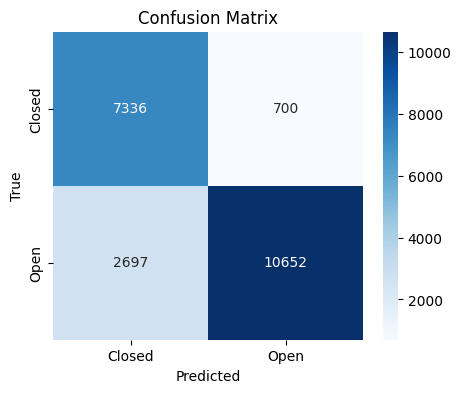

In [ ]:
# ======================================================
# SUBJECT-WISE SPLIT + GRAYSCALE CNN + SUMMARY + METRICS
# ======================================================

import os, glob, cv2, random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# DEVICE & SEED
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ======================================================
# DATASET CLASS 
# ======================================================
class MRLDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fpath = self.files[idx]

        # --- Load grayscale image ---
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)  # 1 channel
        img = cv2.resize(img, (128, 128))

        # Convert to tensor later
        label = int(os.path.basename(fpath).split("_")[4])

        if self.transform:
            img = self.transform(img)

        return img, label


# ======================================================
# SUBJECT-WISE SPLIT
# ======================================================
root = "mrl/mrlEyes_2018_01"

subjects = [
    os.path.join(root, s)
    for s in os.listdir(root)
    if os.path.isdir(os.path.join(root, s))
]

print("Total subjects:", len(subjects))

random.shuffle(subjects)
n = len(subjects)

train_subjects = subjects[:int(0.7*n)]
val_subjects   = subjects[int(0.7*n):int(0.8*n)]
test_subjects  = subjects[int(0.8*n):]

print("Train subjects:", len(train_subjects))
print("Val subjects  :", len(val_subjects))
print("Test subjects :", len(test_subjects))


def collect_files(subj_list):
    files = []
    for s in subj_list:
        files += glob.glob(s + "/**/*.png", recursive=True)
    return files


train_files = collect_files(train_subjects)
val_files   = collect_files(val_subjects)
test_files  = collect_files(test_subjects)

print("Train images:", len(train_files))
print("Val images  :", len(val_files))
print("Test images :", len(test_files))


# ======================================================
# TRANSFORMS 
# ======================================================
train_tfms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
])

test_tfms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
])


# ======================================================
# DATA LOADERS
# ======================================================
train_ds = MRLDataset(train_files, transform=train_tfms)
val_ds   = MRLDataset(val_files, transform=val_tfms)
test_ds  = MRLDataset(test_files, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

print("\nFinal sizes:", len(train_ds), len(val_ds), len(test_ds))


# ======================================================
# SIMPLE CNN MODEL 
# ======================================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),   
            nn.ReLU(),
            nn.MaxPool2d(2),                 # -> 16x64x64

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                 # -> 32x32x32
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# ======================================================
# MODEL SUMMARY
# ======================================================
print("\n======== MODEL SUMMARY ========")
try:
    from torchinfo import summary
    summary(model, input_size=(1, 1, 128, 128))
except:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total params : {total_params:,}")


# ======================================================
# TRAINING LOOP
# ======================================================
def train_model(model, epochs=10):
    for ep in range(epochs):
        model.train()
        total, correct = 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # validation
        model.eval()
        v_correct, v_total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                v_preds = model(imgs).argmax(1)
                v_correct += (v_preds == labels).sum().item()
                v_total += labels.size(0)

        val_acc = v_correct / v_total

        print(f"Epoch {ep+1}/10 | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


# ======================================================
# TESTING + CONFUSION MATRIX
# ======================================================
def evaluate(model):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n========== TEST METRICS ==========")
    print("Accuracy :", accuracy_score(all_labels, all_preds))
    print("Precision:", precision_score(all_labels, all_preds))
    print("Recall   :", recall_score(all_labels, all_preds))
    print("F1 Score :", f1_score(all_labels, all_preds))

    cm = np.zeros((2, 2), dtype=int)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Closed", "Open"],
                yticklabels=["Closed", "Open"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# ======================================================
# RUN
# ======================================================
train_model(model, epochs=10)
evaluate(model)


In [2]:
from torchsummary import summary

print("\n======== MODEL SUMMARY ========")
summary(model, input_size=(1, 128, 128))



======== MODEL SUMMARY ========
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
           Flatten-7                [-1, 32768]               0
            Linear-8                   [-1, 64]       2,097,216
              ReLU-9                   [-1, 64]               0
          Dropout-10                   [-1, 64]               0
           Linear-11                    [-1, 2]             130
Total params: 2,102,146
Trainable params: 2,102,146
Non-trainable params: 0
----------------------------------------------------------